# 🏠 부동산 실거래가 예측 대회 - KKH - EDA
> - 데이터를 분석해보자.
> - kimkihong / helpotcreator@gmail.com / Upstage AI Lab 3기
> - 2024.07.16.화 ~ 2024.07.19.금 19:00

In [76]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(fname=r'font/NanumGothic.otf', name='NanumBarunGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import re
import math

# Model
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder

import eli5
from eli5.sklearn import PermutationImportance


# 모든 열을 표시하도록 설정
pd.set_option('display.max_columns', None)

In [77]:
train = pd.read_csv('data/kkh_train.csv', encoding='utf-8')
test = pd.read_csv('data/test.csv', encoding='utf-8')
subway = pd.read_csv('data/subway_feature.csv', encoding='utf-8')
bus = pd.read_csv('data/bus_feature.csv', encoding='utf-8')

In [78]:
train.sample(2)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,구,동
999087,서울특별시 양천구 신월동,530-7,530.0,7.0,우창,84.68,201002,26,2,2003,신월로17길 21,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22000,양천구,신월동
675866,서울특별시 구로구 개봉동,470,470.0,0.0,삼환,59.40,201411,22,6,1995,남부순환로95길 54,NaN,,-,-,NaN,0226824745,0226846864,NaN,분양,위탁관리,혼합식,개별난방,6.0,783.0,삼환기업(주),영실재건축조합,1995-11-30 00:00:00.0,98554.0,65723.0,64991.0,313.0,226.0,244.0,NaN,NaN,NaN,2024-07-10 21:54:33.0,90700091991,위탁,종합계약,위탁,0.0,691.0,의무,2013-06-05 14:47:08.0,Y,N,126.857983,37.496651,2013-03-07 09:46:25.0,22000,구로구,개봉동


In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118635 entries, 0 to 1118634
Data columns (total 54 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118635 non-null  object 
 1   번지                      1118410 non-null  object 
 2   본번                      1118560 non-null  float64
 3   부번                      1118560 non-null  float64
 4   아파트명                    1116509 non-null  object 
 5   전용면적(㎡)                 1118635 non-null  float64
 6   계약년월                    1118635 non-null  int64  
 7   계약일                     1118635 non-null  int64  
 8   층                       1118635 non-null  int64  
 9   건축년도                    1118635 non-null  int64  
 10  도로명                     1118635 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118635 non-null  object 
 13  거래유형                    1118635 non-null  object 
 14  중개

In [80]:
train.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', '구', '동'],
      dtype='object')

In [81]:
test.sample(2)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
271,서울특별시 강남구 도곡동,467-19,467.0,19.0,현대비젼21,34.995,202309,11,26,1999,언주로30길 10,NaN,20230918,중개거래,서울 강남구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7463,서울특별시 양천구 목동,912,912.0,0.0,목동신시가지5,65.080,202308,25,6,1986,목동동로 350,NaN,,중개거래,서울 양천구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9272 entries, 0 to 9271
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   시군구                     9272 non-null   object 
 1   번지                      9270 non-null   object 
 2   본번                      9272 non-null   float64
 3   부번                      9272 non-null   float64
 4   아파트명                    9262 non-null   object 
 5   전용면적(㎡)                 9272 non-null   float64
 6   계약년월                    9272 non-null   int64  
 7   계약일                     9272 non-null   int64  
 8   층                       9272 non-null   int64  
 9   건축년도                    9272 non-null   int64  
 10  도로명                     9272 non-null   object 
 11  해제사유발생일                 212 non-null    float64
 12  등기신청일자                  9272 non-null   object 
 13  거래유형                    9272 non-null   object 
 14  중개사소재지                  9272 non-null   

In [83]:
test.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일'],
      dtype='object')

In [84]:
subway.head(2)

,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930


In [85]:
bus.head(2)

,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로
1,100000002,1002,창경궁.서울대학교병원,126.996566,37.579183,중앙차로


In [86]:
test['구'] = test['시군구'].apply(lambda x: x.split()[1])
test['동'] = test['시군구'].apply(lambda x: x.split()[2])

In [87]:
train['세대별주차대수'] = train['주차대수'] / train['k-전체세대수']
test['세대별주차대수'] = test['주차대수'] / test['k-전체세대수']

In [88]:
train['계약년'] = train['계약년월'].astype('str').map(lambda x : x[:4]).astype('int')
train['계약월'] = train['계약년월'].astype('str').map(lambda x : x[4:]).astype('int')

test['계약년'] = test['계약년월'].astype('str').map(lambda x : x[:4]).astype('int')
test['계약월'] = test['계약년월'].astype('str').map(lambda x : x[4:]).astype('int')

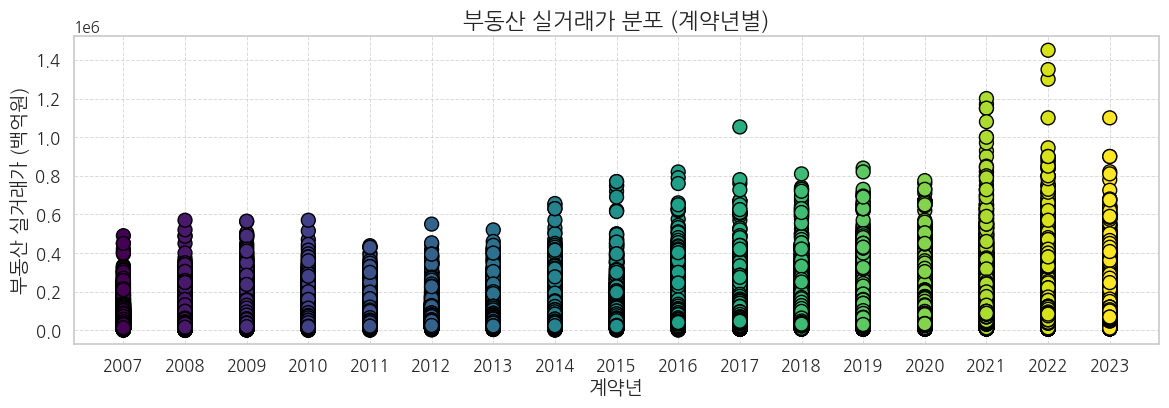

In [101]:
# 데이터 준비: '계약년'과 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['계약년', 'target']].dropna()

# 색상 맵 설정
cmap = plt.get_cmap('viridis')

# '계약년'의 범위를 0에서 1 사이로 정규화하여 색상에 매핑
norm = plt.Normalize(data['계약년'].min(), data['계약년'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.figure(figsize=(14, 4))
scatter = plt.scatter(data['계약년'], data['target'], c=data['계약년'], cmap=cmap, norm=norm, s=100, edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('부동산 실거래가 분포 (계약년별)', fontsize=16, fontweight='bold')
plt.xlabel('계약년', fontsize=14)
plt.ylabel('부동산 실거래가 (백억원)', fontsize=14)

# x축 눈금 설정
years = sorted(data['계약년'].unique())
plt.xticks(ticks=years, labels=[str(year) for year in years], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

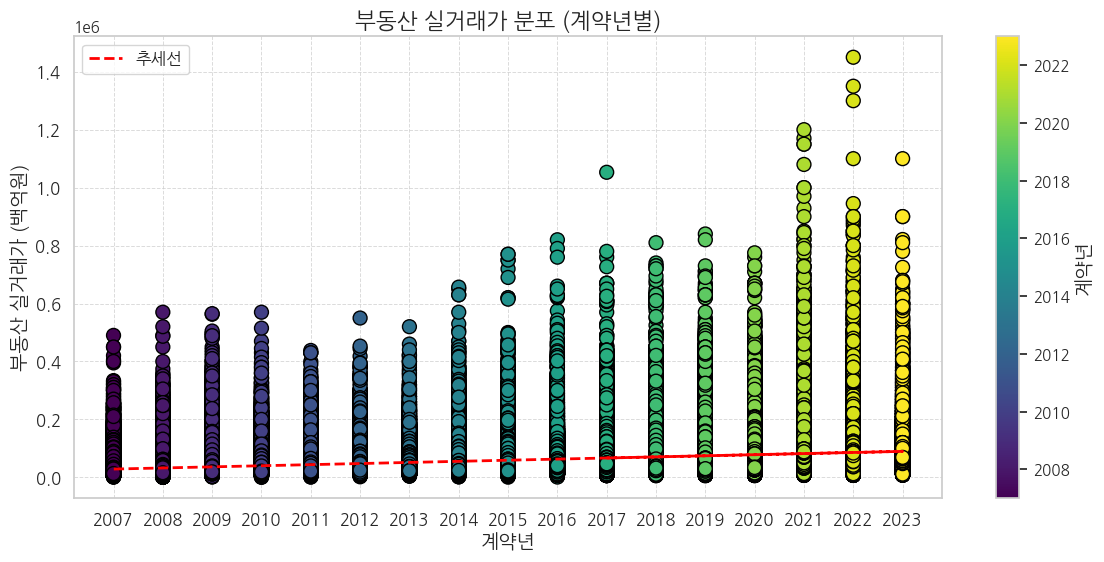

In [148]:
# 데이터 준비: '계약년'과 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['계약년', 'target']].dropna()

# 색상 맵 설정
cmap = plt.get_cmap('viridis')

# '계약년'의 범위를 0에서 1 사이로 정규화하여 색상에 매핑
norm = plt.Normalize(data['계약년'].min(), data['계약년'].max())

# 회귀 분석
coefficients = np.polyfit(data['계약년'], data['target'], 1)  # 1차 다항식(직선) 회귀
polynomial = np.poly1d(coefficients)
regression_line = polynomial(data['계약년'])

# 그래프 그리기
plt.figure(figsize=(14, 6))
scatter = plt.scatter(data['계약년'], data['target'], c=data['계약년'], cmap=cmap, norm=norm, s=100, edgecolor='black')

# 추세선 그리기
plt.plot(data['계약년'], regression_line, color='red', linewidth=2, linestyle='--', label='추세선')

# 컬러바 추가
cbar = plt.colorbar(scatter)
cbar.set_label('계약년', fontsize=14)

# 제목 및 축 레이블 설정
plt.title('부동산 실거래가 분포 (계약년별)', fontsize=16, fontweight='bold')
plt.xlabel('계약년', fontsize=14)
plt.ylabel('부동산 실거래가 (백억원)', fontsize=14)

# x축 눈금 설정
years = sorted(data['계약년'].unique())
plt.xticks(ticks=years, labels=[str(year) for year in years], fontsize=12)
plt.yticks(fontsize=12)

# 그리드 및 범례 설정
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(fontsize=12)

# 차트 표시
plt.show()


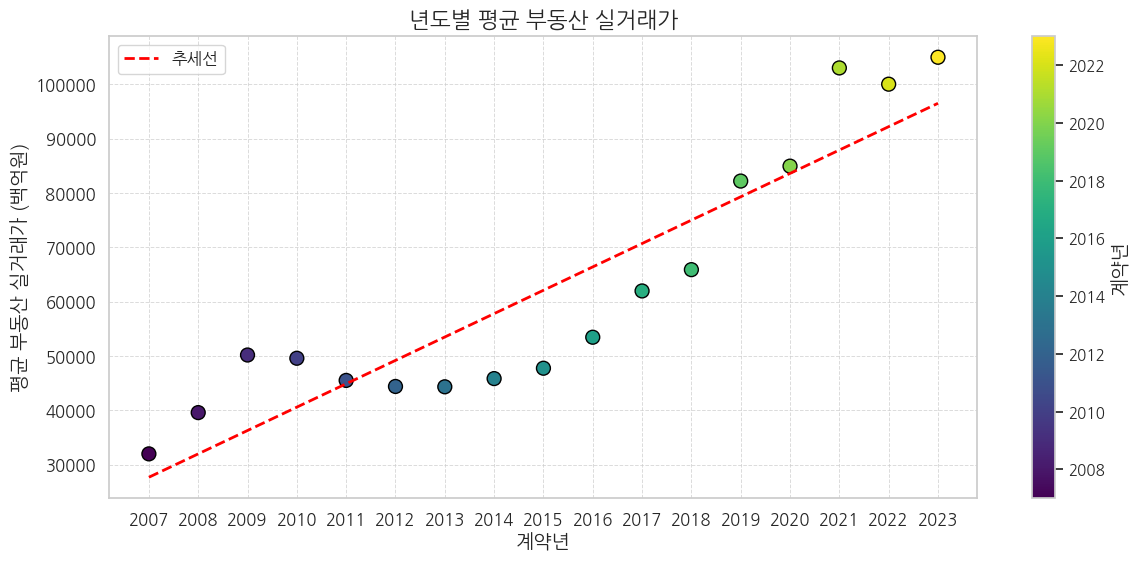

In [149]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 준비: '계약년'과 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['계약년', 'target']].dropna()

# 년도별 평균 가격 계산
yearly_avg_price = data.groupby('계약년')['target'].mean().sort_index()

# 색상 맵 설정
cmap = plt.get_cmap('viridis')

# '계약년'의 범위를 0에서 1 사이로 정규화하여 색상에 매핑
norm = plt.Normalize(yearly_avg_price.index.min(), yearly_avg_price.index.max())

# 회귀 분석
coefficients = np.polyfit(yearly_avg_price.index, yearly_avg_price.values, 1)  # 1차 다항식(직선) 회귀
polynomial = np.poly1d(coefficients)
regression_line = polynomial(yearly_avg_price.index)

# 그래프 그리기
plt.figure(figsize=(14, 6))
scatter = plt.scatter(yearly_avg_price.index, yearly_avg_price.values, c=yearly_avg_price.index, cmap=cmap, norm=norm, s=100, edgecolor='black')

# 추세선 그리기
plt.plot(yearly_avg_price.index, regression_line, color='red', linewidth=2, linestyle='--', label='추세선')

# 컬러바 추가
cbar = plt.colorbar(scatter)
cbar.set_label('계약년', fontsize=14)

# 제목 및 축 레이블 설정
plt.title('년도별 평균 부동산 실거래가', fontsize=16, fontweight='bold')
plt.xlabel('계약년', fontsize=14)
plt.ylabel('평균 부동산 실거래가 (억원)', fontsize=14)

# x축 눈금 설정
years = sorted(yearly_avg_price.index)
plt.xticks(ticks=years, labels=[str(year) for year in years], fontsize=12)
plt.yticks(fontsize=12)

# 그리드 및 범례 설정
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(fontsize=12)

# 차트 표시
plt.show()


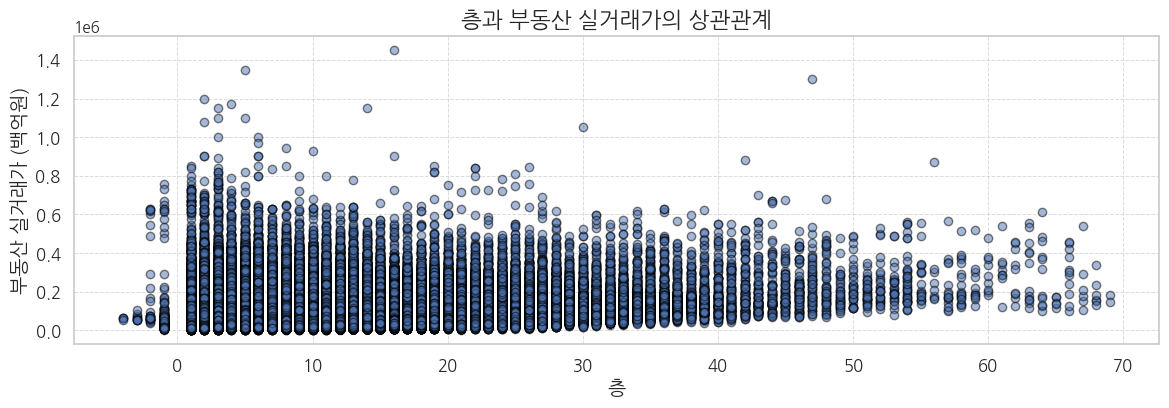

In [193]:
# 데이터 준비: '층'과 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['층', 'target']].dropna()

plt.figure(figsize=(14, 4))
plt.scatter(data['층'], data['target'], alpha=0.5, edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('층과 부동산 실거래가의 상관관계', fontsize=16, fontweight='bold')
plt.xlabel('층', fontsize=14)
plt.ylabel('부동산 실거래가 (백억원)', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()


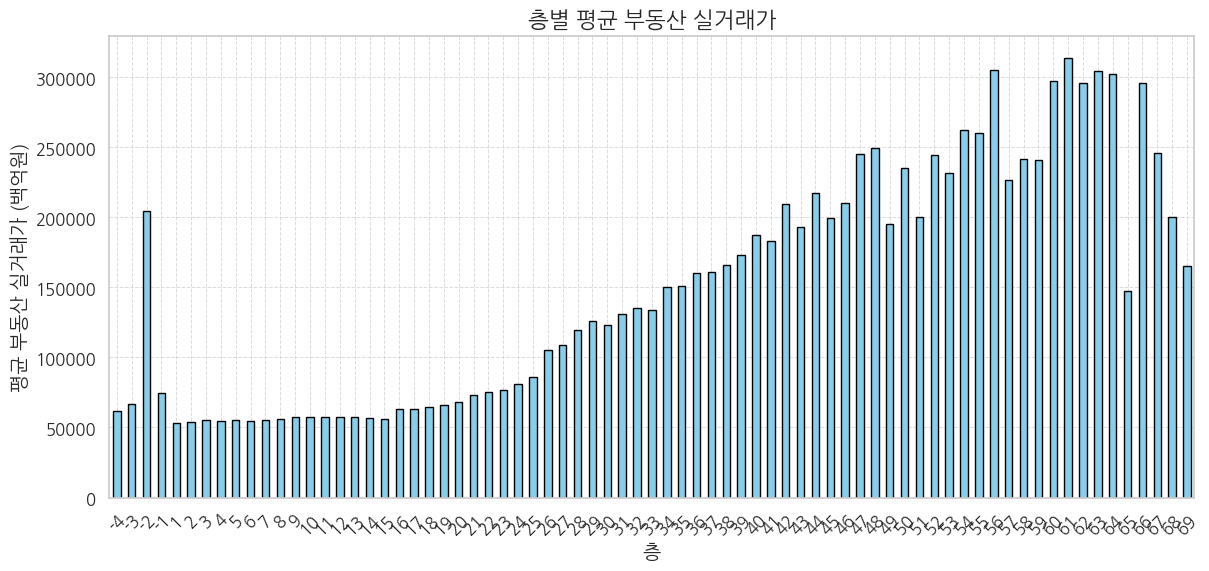

In [194]:
import matplotlib.pyplot as plt

# 데이터 준비: '층'과 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['층', 'target']].dropna()

# 층별 평균 거래가를 계산합니다.
mean_prices_per_floor = data.groupby('층')['target'].mean()

plt.figure(figsize=(14, 6))
mean_prices_per_floor.plot(kind='bar', color='skyblue', edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('층별 평균 부동산 실거래가', fontsize=16, fontweight='bold')
plt.xlabel('층', fontsize=14)
plt.ylabel('평균 부동산 실거래가 (백억원)', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.show()


In [200]:
floor = 2
print(f'{floor}층 미만: ', train[(floor == train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean())
print(f'{floor}층 이상: ', train[(floor < train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean())

2층 미만:  53653.02856660564
2층 이상:  58683.04427284876


In [207]:
floor_diff_value_list = dict()
for floor in range(1, 100, 1):
    diff = train[((floor+1) == train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean() - train[(floor == train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean()
    if np.isnan(diff):
        break
    floor_diff_value_list[floor] = int(diff)

print(floor_diff_value_list)

{1: 771, 2: 1411, 3: -354, 4: 587, 5: -447, 6: 499, 7: 867, 8: 929, 9: 60, 10: 255, 11: 299, 12: -174, 13: -460, 14: -1223, 15: 7164, 16: -169, 17: 1742, 18: 1171, 19: 2419, 20: 5135, 21: 2231, 22: 1029, 23: 4264, 24: 5110, 25: 19354, 26: 3577, 27: 10545, 28: 6295, 29: -2880, 30: 8414, 31: 4131, 32: -1443, 33: 16650, 34: 527, 35: 9371, 36: 597, 37: 4955, 38: 7222, 39: 14409, 40: -4423, 41: 26081, 42: -15990, 43: 24077, 44: -18092, 45: 10715, 46: 35104, 47: 4414, 48: -54621, 49: 40098, 50: -34468, 51: 44140, 52: -12884, 53: 30348, 54: -2166, 55: 45433, 56: -79092, 57: 15381, 58: -607, 59: 56540, 60: 16402, 61: -18513, 62: 8638, 63: -2159, 64: -154430, 65: 148521, 66: -50098, 67: -45875, 68: -35208}


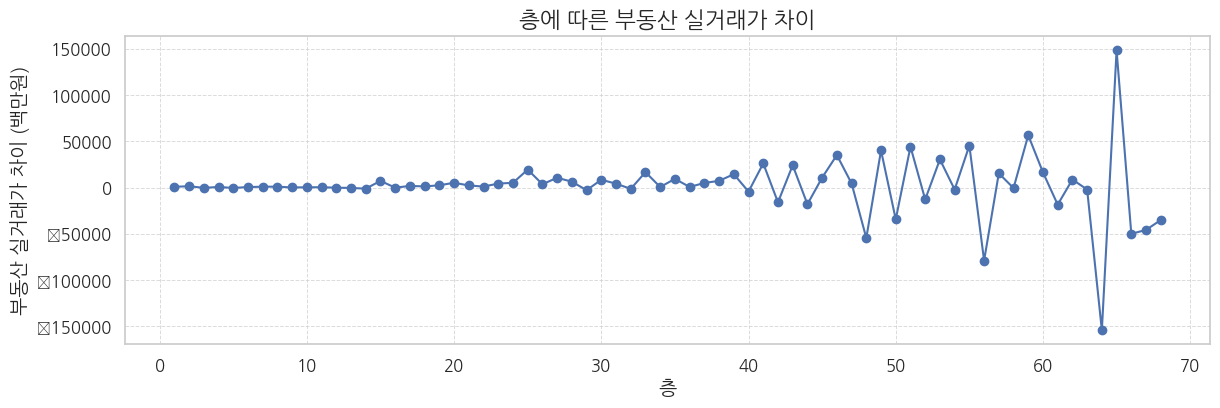

In [208]:
plt.figure(figsize=(14, 4))
plt.plot(floor_diff_value_list.keys(), floor_diff_value_list.values(), marker='o', linestyle='-', color='b')

# 제목 및 축 레이블 설정
plt.title('층에 따른 부동산 실거래가 차이', fontsize=16, fontweight='bold')
plt.xlabel('층', fontsize=14)
plt.ylabel('부동산 실거래가 차이 (백만원)', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.show()

In [209]:
floor_diff_value_list = dict()
for floor in range(2, 100, 1):
    diff = train[(floor < train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean() - train[(floor >= train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean()
    if np.isnan(diff):
        break
    floor_diff_value_list[floor] = int(diff)

print(floor_diff_value_list)

{2: 5324, 3: 5039, 4: 5276, 5: 5505, 6: 6002, 7: 6503, 8: 6945, 9: 7361, 10: 7992, 11: 8837, 12: 9986, 13: 11603, 14: 14083, 15: 18236, 16: 20232, 17: 23090, 18: 26612, 19: 31019, 20: 36335, 21: 41132, 22: 47306, 23: 55384, 24: 64834, 25: 75618, 26: 81328, 27: 87985, 28: 93396, 29: 98236, 30: 104457, 31: 109650, 32: 115413, 33: 122484, 34: 128137, 35: 135099, 36: 141527, 37: 147237, 38: 152991, 39: 158899, 40: 162612, 41: 167524, 42: 169703, 43: 174402, 44: 176321, 45: 181098, 46: 186482, 47: 186341, 48: 185534, 49: 191278, 50: 193000, 51: 200244, 52: 201848, 53: 205645, 54: 206001, 55: 206560, 56: 203915, 57: 208795, 58: 214066, 59: 218362, 60: 215611, 61: 210379, 62: 205750, 63: 193890, 64: 175477, 65: 192638, 66: 156845, 67: 133411, 68: 107004}


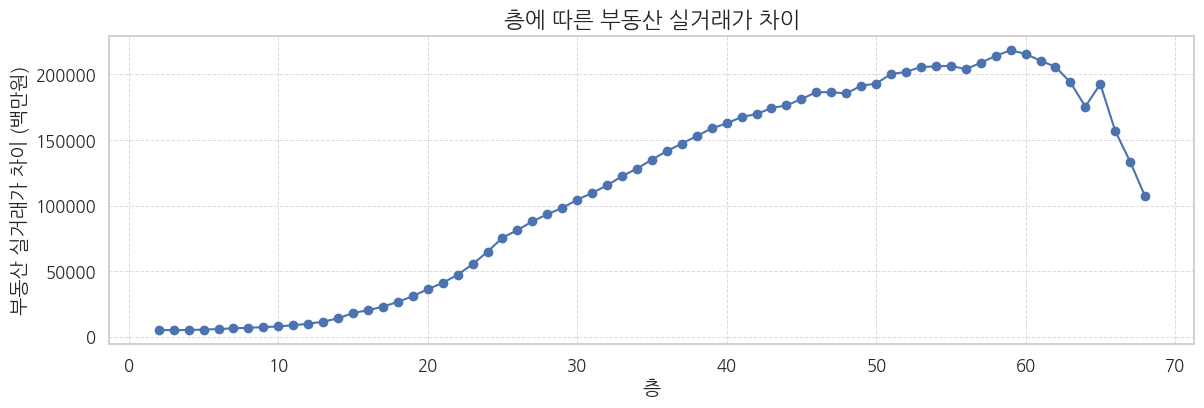

In [210]:
plt.figure(figsize=(14, 4))
plt.plot(floor_diff_value_list.keys(), floor_diff_value_list.values(), marker='o', linestyle='-', color='b')

# 제목 및 축 레이블 설정
plt.title('층에 따른 부동산 실거래가 차이', fontsize=16, fontweight='bold')
plt.xlabel('층', fontsize=14)
plt.ylabel('부동산 실거래가 차이 (백만원)', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.show()

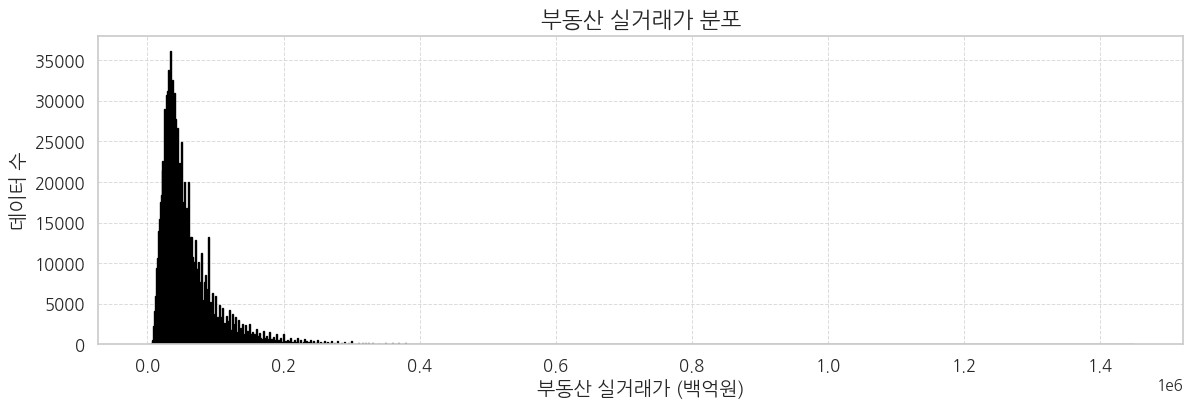

In [110]:
# 데이터 준비: 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['target']].dropna()

# 히스토그램을 생성합니다.
plt.figure(figsize=(14, 4))
plt.hist(data['target'], bins=1000, edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('부동산 실거래가 분포', fontsize=16, fontweight='bold')
plt.xlabel('부동산 실거래가 (백억원)', fontsize=14)
plt.ylabel('데이터 수', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.show()

###  == 위 차트 분석 결과 ==

- 양의 왜도(Right skewed) 형태이다.
- 0 ~ 10억 사이의 데이터가 가장 많다.
- 20억 이상하는 부동산은 데이터 양이 적으니, 예측이 어려울 것이다.

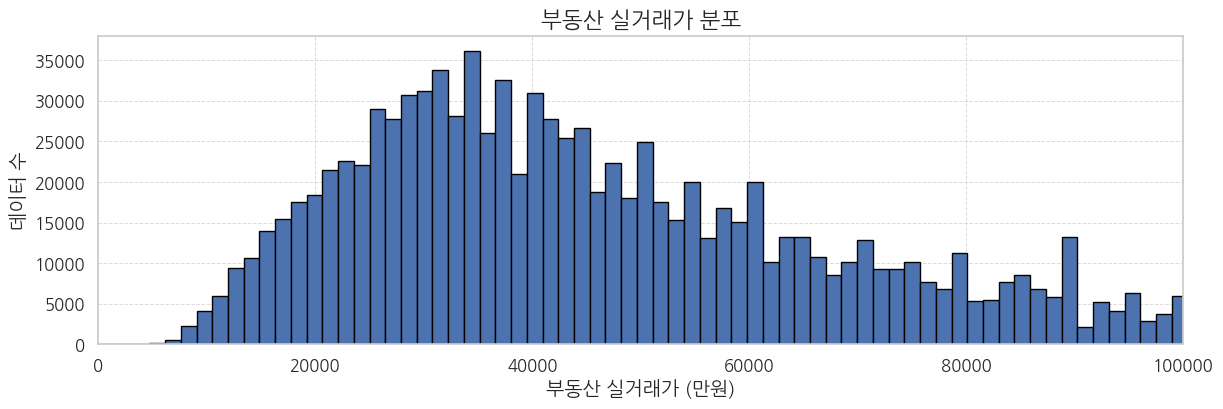

In [119]:
# 데이터 준비: 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['target']].dropna()

# 히스토그램을 생성합니다.
plt.figure(figsize=(14, 4))
plt.hist(data['target'], bins=1000, edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('부동산 실거래가 분포', fontsize=16, fontweight='bold')
plt.xlabel('부동산 실거래가 (만원)', fontsize=14)
plt.ylabel('데이터 수', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 100000)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

### == 위 차트 분석 결과 ==

- 앞서 살펴보았던 차트에서, 가장 데이터가 많았던 부분만 확대한 차트이다.
- 3억 ~ 4억 부근의 데이터가 가장 많다.

In [123]:
print('target의 max: ', train['target'].max())
print('target의 min: ', train['target'].min())

target의 max:  1450000
target의 min:  350


In [128]:
print(train[train['target'] < 1000])

                     시군구      번지      본번    부번   아파트명  전용면적(㎡)    계약년월  계약일  \
197715     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   88.930  200812    1   
197716     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   83.700  200812    1   
197717     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   83.700  200812    1   
197718     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197719     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197720     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   83.700  200812    1   
197721     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197722     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197723     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197724     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   83.700  200812    1   
197725     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197726     서울특별시 은평구 구산동  199-24   199.0  24.0     신

In [129]:
print('계약년월의 max: ', train['계약년월'].max())
print('계약년월의 min: ', train['계약년월'].min())

계약년월의 max:  202306
계약년월의 min:  200701


In [134]:
print('아파트 종류: ', len(train['아파트명'].unique()))
display(train['아파트명'].value_counts()[:10])

아파트 종류:  6532


현대       16610
신동아      12846
한신        9074
두산        8533
주공2       7918
우성        7768
벽산        7285
삼성래미안     7143
대림        6305
극동        5669
Name: 아파트명, dtype: int64

In [135]:
train['구'].value_counts()[:10]

노원구    115099
송파구     73735
강남구     69075
강서구     66610
강동구     61895
구로구     57604
성북구     56660
양천구     53977
서초구     53123
도봉구     52572
Name: 구, dtype: int64

In [136]:
train['동'].value_counts()[:10]

상계동    44948
중계동    26357
신정동    24038
창동     23101
구로동    22811
봉천동    20511
목동     17246
월계동    17056
서초동    15896
공릉동    15763
Name: 동, dtype: int64

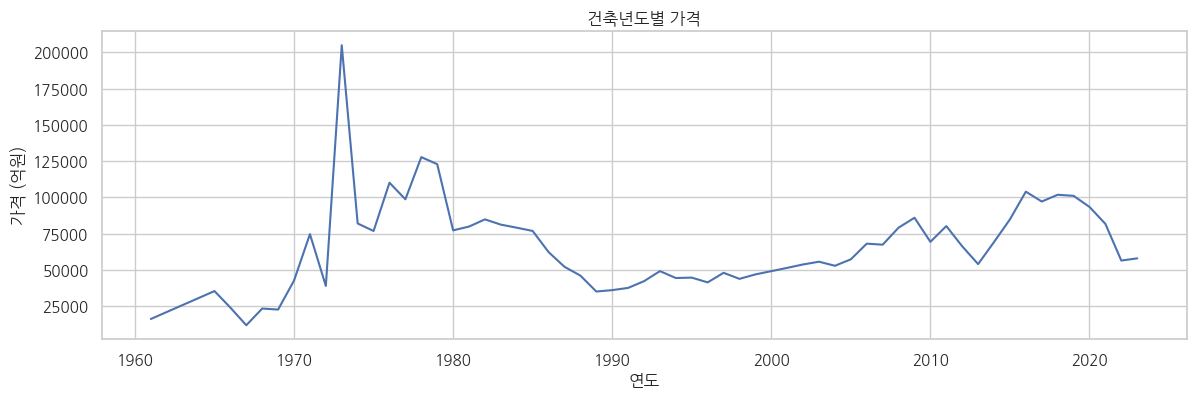

In [146]:
train_yearly = train.groupby(train['건축년도'])['target'].mean()

plt.figure(figsize=(14, 4))
plt.plot(train_yearly.index, train_yearly.values)
plt.xlabel('연도')
plt.ylabel('가격 (억원)')
plt.title('건축년도별 가격')
plt.show()

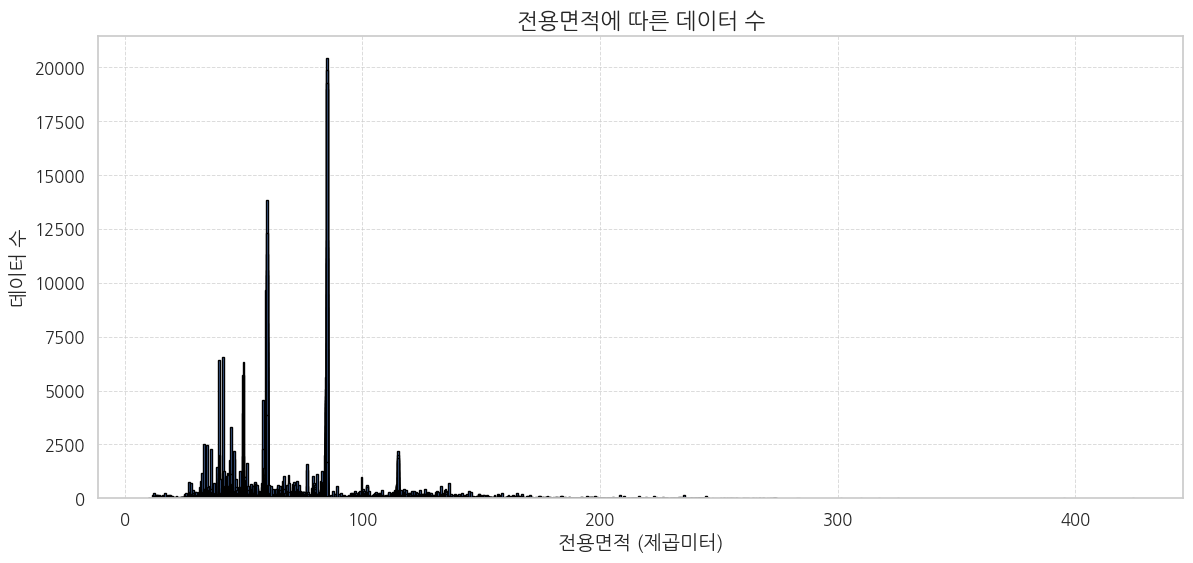

In [142]:
# 데이터 준비: 'area'와 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['전용면적(㎡)']].dropna()

# 전용면적별 데이터 수를 계산합니다.
area_counts = data['전용면적(㎡)'].value_counts().sort_index()

# 라인 차트를 그립니다.
plt.figure(figsize=(14, 6))
plt.bar(area_counts.index, area_counts.values, color='b', edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('전용면적에 따른 데이터 수', fontsize=16, fontweight='bold')
plt.xlabel('전용면적 (제곱미터)', fontsize=14)
plt.ylabel('데이터 수', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12, rotation=45)  # x축 레이블을 더 잘 보이도록 회전
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

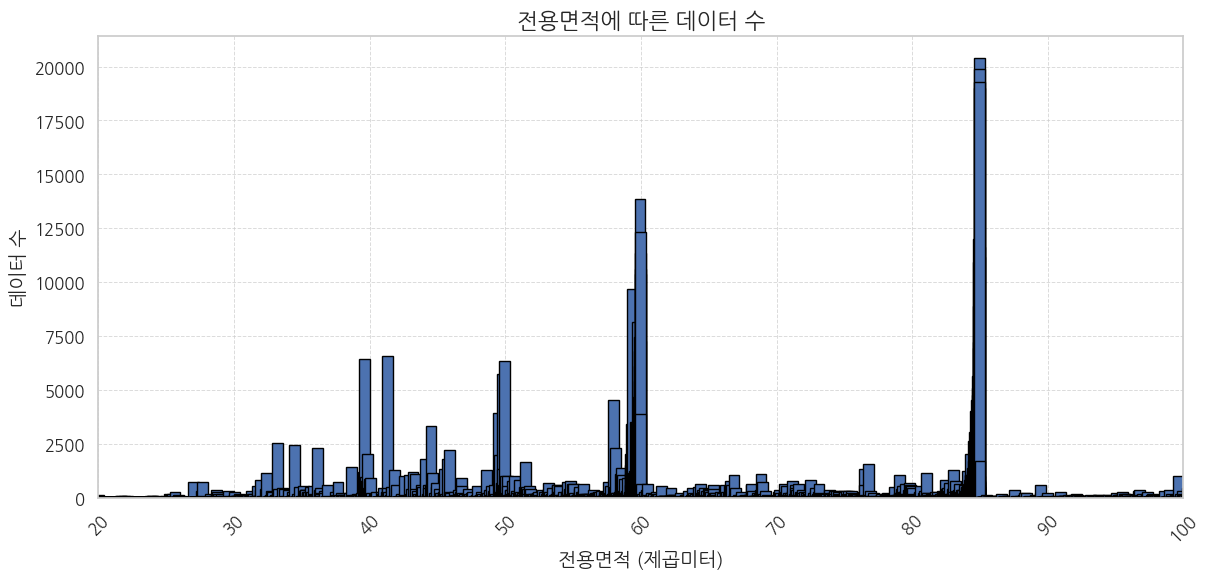

In [144]:
# 데이터 준비: 'area'와 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['전용면적(㎡)']].dropna()

# 전용면적별 데이터 수를 계산합니다.
area_counts = data['전용면적(㎡)'].value_counts().sort_index()

# 라인 차트를 그립니다.
plt.figure(figsize=(14, 6))
plt.bar(area_counts.index, area_counts.values, color='b', edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('전용면적에 따른 데이터 수', fontsize=16, fontweight='bold')
plt.xlabel('전용면적 (제곱미터)', fontsize=14)
plt.ylabel('데이터 수', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12, rotation=45)  # x축 레이블을 더 잘 보이도록 회전
plt.yticks(fontsize=12)
plt.xlim(20, 100)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

In [223]:
selected_feature_list = ['아파트명', '전용면적(㎡)', '건축년도', 'k-세대타입(분양형태)', 'k-복도유형', 'k-난방방식', 'k-시행사', '구', '동', '세대별주차대수']
test = test[selected_feature_list]

selected_feature_list.append('target')
train = train[selected_feature_list]

In [224]:
# 컬럼명에서 '(㎡)', 'k-', '(아파트,주상복합등등)', '(분양형태)' 삭제
def clean_column_name(name):
    name = re.sub(r'k-', '', name)
    name = re.sub(r'\(.*?\)', '', name)
    return name.strip()

# train과 test 데이터프레임의 컬럼명 정리
train.columns = [clean_column_name(col) for col in train.columns]
test.columns = [clean_column_name(col) for col in test.columns]

display(train.head(2))
display(test.head(2))

,아파트명,전용면적,건축년도,세대타입,복도유형,난방방식,시행사,구,동,세대별주차대수,target
0,개포6차우성,79.97,1987,분양,계단식,개별난방,모름,강남구,개포동,0.97037,124000
1,개포6차우성,79.97,1987,분양,계단식,개별난방,모름,강남구,개포동,0.97037,123500


,아파트명,전용면적,건축년도,세대타입,복도유형,난방방식,시행사,구,동,세대별주차대수
0,개포6차우성,79.9700,1987,분양,계단식,개별난방,모름,강남구,개포동,0.970370
1,개포더샵트리에,108.2017,2021,분양,계단식,지역난방,개포우성9차모델링조합,강남구,개포동,1.314655


In [225]:
def eda_kkh(df: pd.DataFrame):
    desc = pd.DataFrame(index = list(df))
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] /len(df) * 100
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc = pd.concat([desc, df.describe().T.drop('count',axis=1)],axis=1)
    return desc.sort_values(by=['type','null']).style.background_gradient(cmap='YlOrBr')\
        .bar(subset=['mean'],color='green')\
        .bar(subset=['max'],color='red')\
        .bar(subset=['min'], color='purple')

eda_kkh(train)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
건축년도,int64,1118822,60,0.005363,0,0.000000,1998.755327,9.333908,1961.000000,1992.000000,2000.000000,2005.000000,2023.000000
target,int64,1118822,14530,1.298687,0,0.000000,57991.532149,46426.021936,350.000000,30500.000000,44800.000000,69800.000000,1450000.000000
전용면적,float64,1118822,14617,1.306463,0,0.000000,77.174747,29.364231,10.020000,59.650000,81.880000,84.960000,424.320000
세대별주차대수,float64,863687,2083,0.186178,255135,22.803896,0.929921,0.488362,0.000000,0.589391,1.022222,1.206897,4.674487
구,object,1118822,25,0.002234,0,0.000000,nan,nan,nan,nan,nan,nan,nan
동,object,1118822,337,0.030121,0,0.000000,nan,nan,nan,nan,nan,nan,nan
아파트명,object,1116696,6538,0.584365,2126,0.190021,nan,nan,nan,nan,nan,nan,nan
난방방식,object,866729,4,0.000358,252093,22.532002,nan,nan,nan,nan,nan,nan,nan
세대타입,object,866131,5,0.000447,252691,22.585451,nan,nan,nan,nan,nan,nan,nan
복도유형,object,866036,5,0.000447,252786,22.593943,nan,nan,nan,nan,nan,nan,nan


In [226]:
eda_kkh(test)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
건축년도,int64,9272,57,0.614754,0,0.000000,2003.034944,11.179837,1961.000000,1996.000000,2003.000000,2012.000000,2023.000000
전용면적,float64,9272,2590,27.933563,0,0.000000,75.414506,29.343517,12.000000,59.700000,76.570000,84.960000,301.470000
세대별주차대수,float64,2709,520,5.608283,6563,70.783003,1.058788,0.480178,0.000000,0.877778,1.153617,1.271924,2.904040
구,object,9272,25,0.269629,0,0.000000,nan,nan,nan,nan,nan,nan,nan
동,object,9272,268,2.890423,0,0.000000,nan,nan,nan,nan,nan,nan,nan
아파트명,object,9262,2170,23.403796,10,0.107852,nan,nan,nan,nan,nan,nan,nan
세대타입,object,2710,3,0.032355,6562,70.772217,nan,nan,nan,nan,nan,nan,nan
난방방식,object,2710,4,0.043141,6562,70.772217,nan,nan,nan,nan,nan,nan,nan
복도유형,object,2708,5,0.053926,6564,70.793788,nan,nan,nan,nan,nan,nan,nan
시행사,object,2692,440,4.745470,6580,70.966350,nan,nan,nan,nan,nan,nan,nan


In [227]:
train = train.dropna()
print(train.isnull().sum())

아파트명       0
전용면적       0
건축년도       0
세대타입       0
복도유형       0
난방방식       0
시행사        0
구          0
동          0
세대별주차대수    0
target     0
dtype: int64


In [228]:
train.sample(5)

,아파트명,전용면적,건축년도,세대타입,복도유형,난방방식,시행사,구,동,세대별주차대수,target
695343,한신,84.940,1995,분양,계단식,개별난방,한신공영,도봉구,도봉동,0.919343,28000
943245,천연뜨란채,55.850,2006,분양,혼합식,개별난방,대한주택공사,서대문구,천연동,0.782738,31500
471150,대림e-편한세상5,84.789,2003,분양,계단식,개별난방,대림산업(주),구로구,신도림동,1.135359,60000
679912,대림2,84.950,2001,분양,혼합식,개별난방,종근당외,구로구,신도림동,1.229765,49500
442093,개포주공4단지,41.990,1982,기타,혼합식,지역난방,개포주공4단지주택재건축조합,강남구,개포동,1.742519,103000


In [229]:
SEED = 1053682552
TARGET = 'target'
NUMERIC_COLS = [f for f in train._get_numeric_data() if f != TARGET]
CAT_COLS = list(test.drop(NUMERIC_COLS,axis=1))

print(f'Target         --> {TARGET}')
print(f'Numeric Cols   --> {NUMERIC_COLS}')
print(f'Categoric Cols --> {CAT_COLS}')


Target         --> target
Numeric Cols   --> ['전용면적', '건축년도', '세대별주차대수']
Categoric Cols --> ['아파트명', '세대타입', '복도유형', '난방방식', '시행사', '구', '동']


In [230]:
def ChangeType(df):
    for c in CAT_COLS:
        df[c] = df[c].astype('category')
    return df
ChangeTypeTransf = FunctionTransformer(ChangeType)

# train 데이터와 test 데이터 합치기
Xadv =  pd.concat([train, test], axis=0)
# yadv = adversarial target
# train과 test를 구분하기 위해, 0을 넣고 1을 넣는다.
yadv = [0] * len(train) + [1] * len(test)
Xadv = Xadv.drop(TARGET, axis=1)


model = make_pipeline(ChangeTypeTransf, XGBClassifier(random_state=SEED, enable_categorical=True))
# n_jobs=-1은 CPU의 모든 코어를 이용해서, 병렬 처리하라는 뜻이다.
cv_preds = cross_val_predict(model, Xadv, yadv, cv=5, n_jobs=-1, method='predict_proba')
score = roc_auc_score(y_true=yadv, y_score=cv_preds[:, 1])
print(f"roc-auc score: {score:0.3f}")

roc-auc score: 0.811


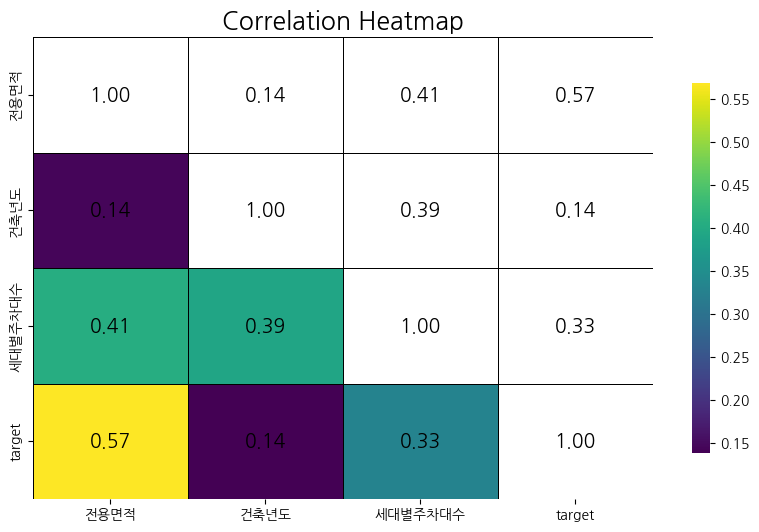

In [231]:
# 상관 행렬 계산
corr = train[NUMERIC_COLS + [TARGET]].corr()

# 마스크 생성
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 조정
ax = sns.heatmap(corr, mask=mask, cmap='viridis', linewidths=0.5, linecolor='black', cbar_kws={"shrink": .8})

# 각 셀에 숫자 추가
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        text = f"{corr.iloc[i, j]:.2f}"
        ax.text(j + 0.5, i + 0.5, text,
                ha='center', va='center',
                color='black',  # 글자색 검은색
                fontsize=14,    # 글자 크기 조정
                fontweight='bold')  # 글자 굵게

# 타이틀 추가
plt.title('Correlation Heatmap', size=18)

# 그래프 표시
plt.show()

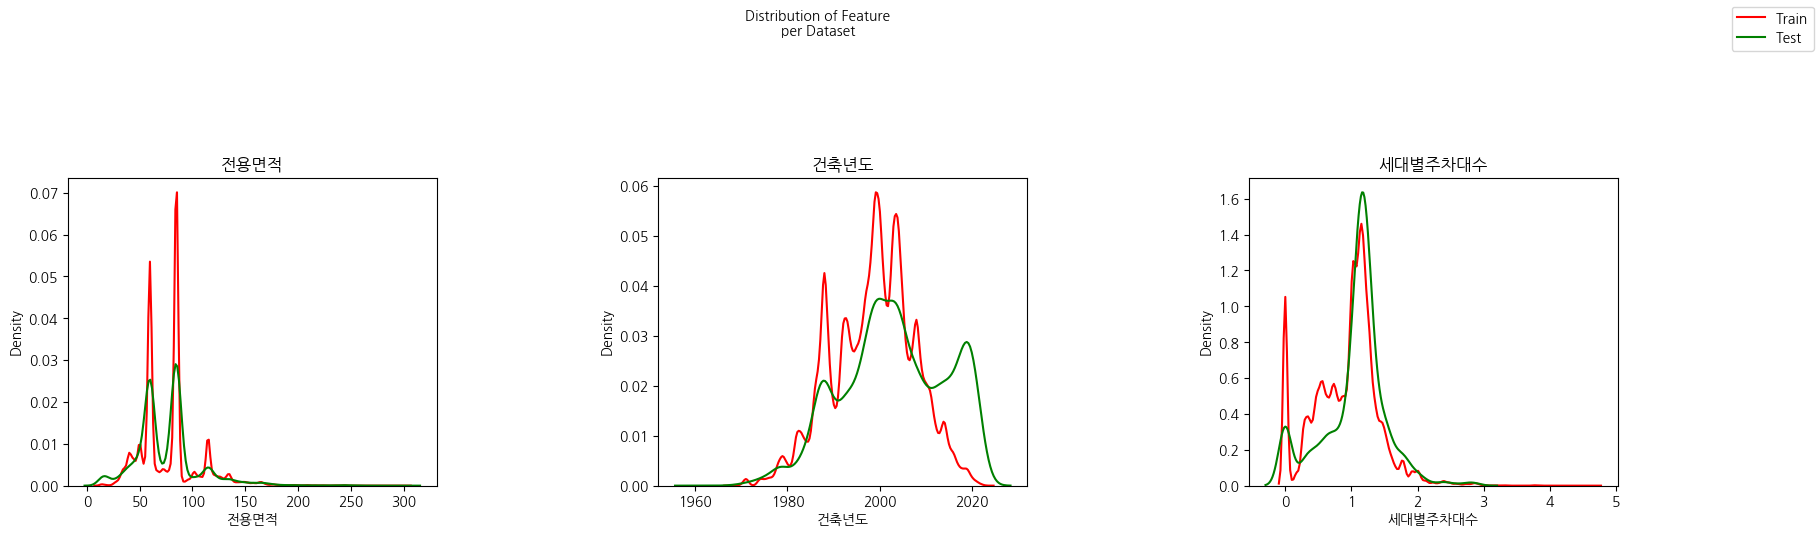

In [232]:
n_cols = 3
n_rows = math.ceil(len(NUMERIC_COLS)/n_cols)
fig, ax = plt.subplots(1,n_cols, figsize=(20,n_rows*4))
ax = ax.flatten()
plt.subplots_adjust(wspace=0.6)
for i,c in enumerate(NUMERIC_COLS):
    sns.kdeplot(train[c],color='red',ax=ax[i])
    sns.kdeplot(test[c],color='green',ax=ax[i])
    ax[i].set_title(f'{c}')
for j in range(len(NUMERIC_COLS),len(ax)):
    ax[j].axis('off')
fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 10 ,fontweight = 'bold',y=1.30)
fig.legend(['Train', 'Test'],loc='upper right')
plt.show()
    

In [233]:
def plot_categorical():
    fig, ax = plt.subplots(len(CAT_COLS), 2, figsize = (16, len(CAT_COLS)*6))

    for i, column in enumerate(CAT_COLS):
        ax[i][0].pie(
            train[column].value_counts(), 
            shadow = True, 
            explode = [.1 for i in range(train[column].nunique())], 
            autopct = '%1.f%%',
            textprops = {'size' : 14, 'color' : 'white'}
        )
        
        sns.countplot(x=train[column], ax=ax[i][1])
        ax[i][1].set_title(f'{column}')
        ax[i][1].set_ylabel('Count')
        ax[i][1].set_xlabel(column)
        ax[i][1].tick_params(axis='x', labelrotation=45)

        
    plt.tight_layout()
    plt.show()

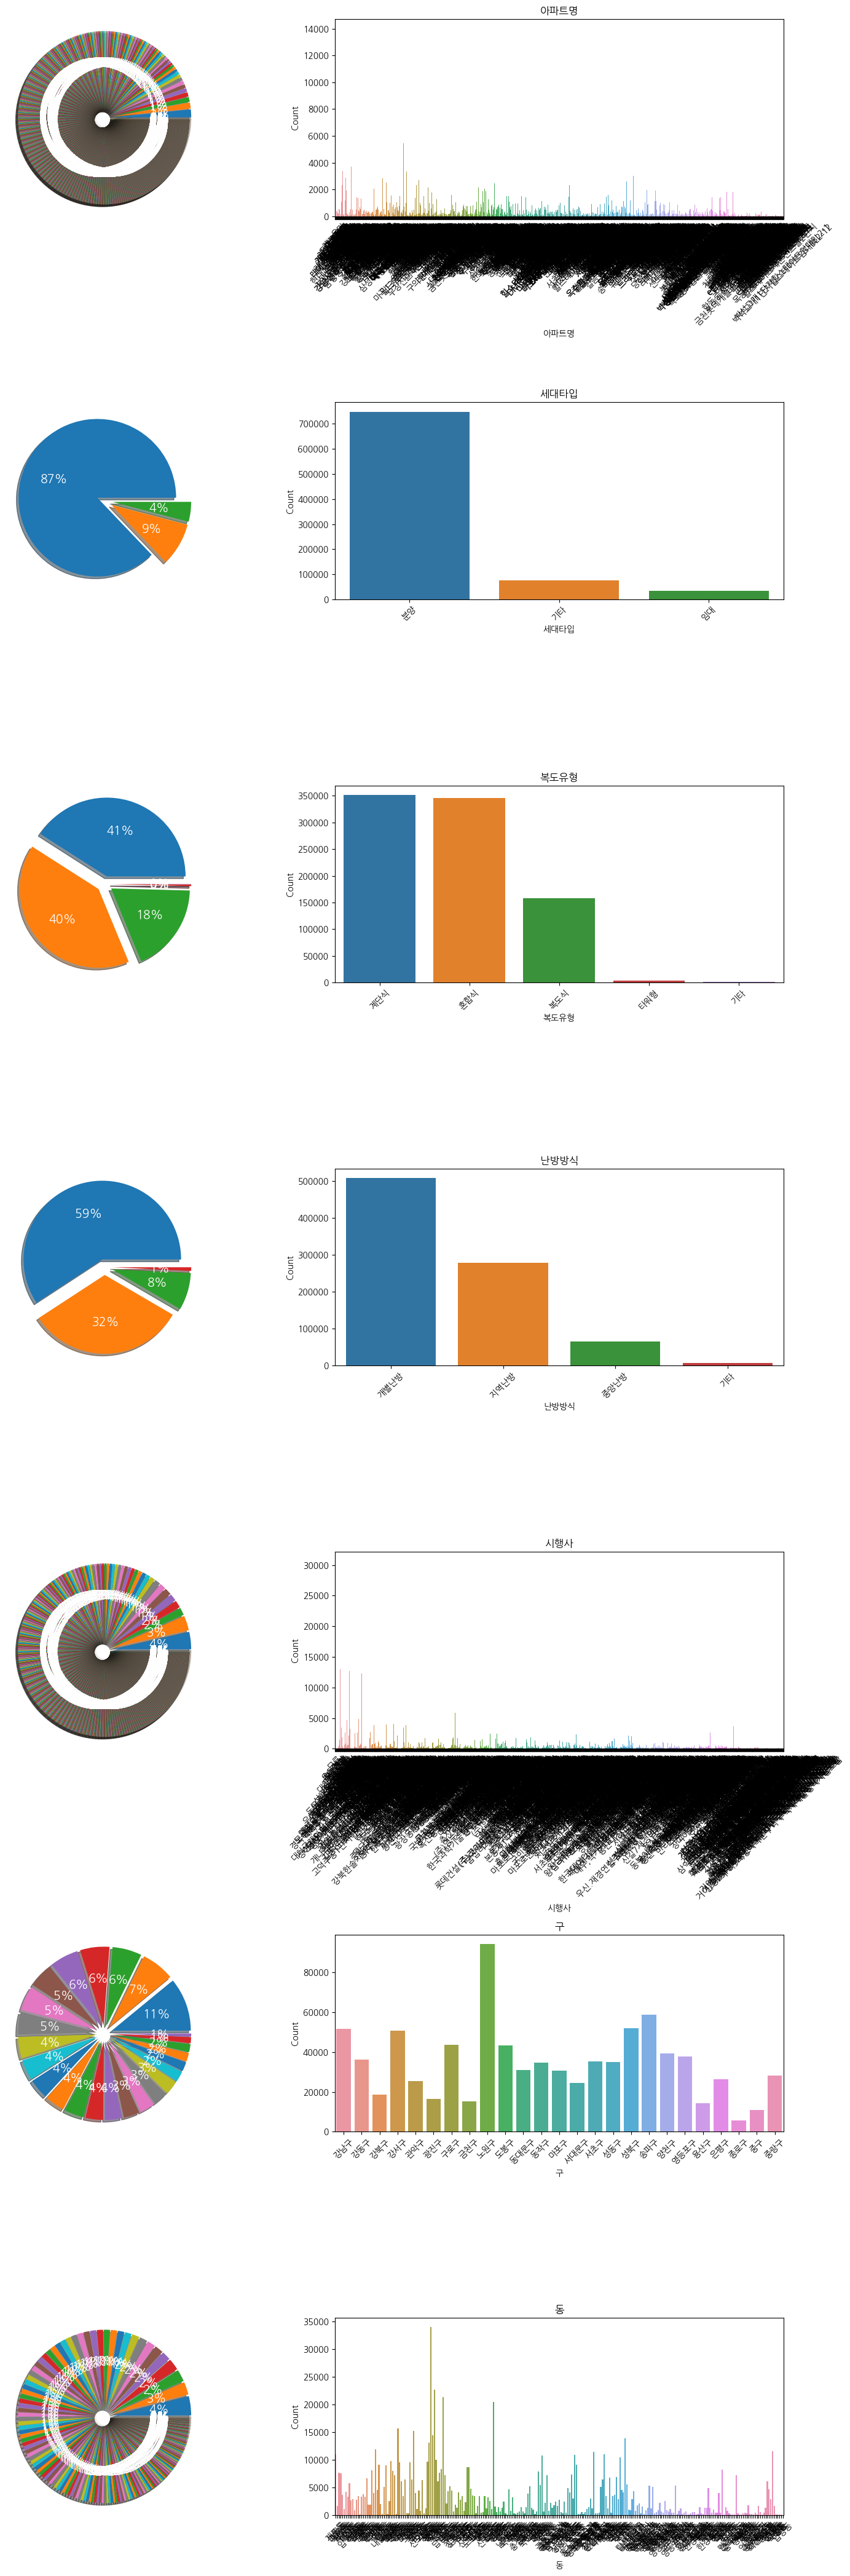

In [234]:
plot_categorical()